In [1]:
import pandas as pd

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score
from sklearn.metrics import plot_confusion_matrix

import matplotlib.pyplot as plt

from catboost import CatBoostClassifier, Pool

import warnings
warnings.filterwarnings("ignore")

In [2]:
monitorings = pd.read_csv('data/row/monitorings.csv')

## Подготовим данные для обучения моделей

In [50]:
def clean_data(df):
    df.fillna(0)
    df.drop_duplicates(inplace=True)
    df = df.query('day_of_week == 1')
    df = df.sort_values(by='date')
    df.drop(['day_of_week', 'date'], axis = 1, inplace=True)
    
    return df

In [51]:
def add_features(df):
    df['price_deviation'] = abs(1 - (df['price'] / df['day_mean_price']))
    df['product_percetage_checkmons'] = df['product_count_checkmons'] / df['product_count_mons']
    df['shop_percetage_checkmons'] = df['shop_count_checkmons'] / df['shop_count_mons']
    df['competitor_percetage_checkmons'] = df['competitor_count_checkmons'] / df['competitor_count_mons']
    
    return df

In [52]:
def split_data(df):
    x_train, x_test, y_train, y_test = train_test_split(df.drop('wrong_monitoring', axis = 1),
                                                        df['wrong_monitoring'],
                                                        test_size=0.1,
                                                        random_state = 55)  
    return x_train, x_test, y_train, y_test

In [53]:
def feature_importances_analysis(df):
    
    x_train, x_test, y_train, y_test = split_data(df)
    
    model = CatBoostClassifier(
        cat_features=['shop_id','product_name', 'task_name',\
                  'competitor', 'region_id', 'city_id', 'group_id', \
                  'category_id', 'task_comment', 'product_comment'], 
        iterations = 250,
        random_seed=42
    )

    model.fit(x_train,
              y_train,
              eval_set=(x_test, y_test)
    )
    
    feature_names = x_train.columns
    
    return model, feature_names

In [54]:
def importance_feature(model, feature_names):  
    score_data = []
    feature_importances = model.feature_importances_
    for score, name in sorted(zip(feature_importances, feature_names), reverse=False):
        score_data.append([round(score, 2), name])
    score_data.append([1.0, 'wrong_monitoring'])
    
    return score_data

In [55]:
def processed_df(df, score_data):
    features = pd.DataFrame(data=score_data, columns=['score', 'feature'])
    features = features.query('score > 0.05')
    
    df = df[features['feature'].unique()]
    df.to_csv('data/processed/clean_monitorings.csv', index=False)   
    
    return df

In [89]:
# Очистим данные от пропусков, дубликатов и лишних столбцов
monitorings = clean_data(monitorings)
    
# Добавим новые столбцы
monitorings = add_features(monitorings)
    
# Проанализируем важность каждого признака
model_for_feature, feature_names = feature_importances_analysis(monitorings)

# Получим значения влияния каждого признака
score_data = importance_feature(model_for_feature, feature_names)

# Удалим невлияющие признаки
monitorings = processed_df(monitorings, score_data)

Learning rate set to 0.209863
0:	learn: 0.4170055	test: 0.4139353	best: 0.4139353 (0)	total: 197ms	remaining: 49.2s
1:	learn: 0.2912830	test: 0.2872536	best: 0.2872536 (1)	total: 397ms	remaining: 49.2s
2:	learn: 0.2344048	test: 0.2292919	best: 0.2292919 (2)	total: 617ms	remaining: 50.8s
3:	learn: 0.1931118	test: 0.1874675	best: 0.1874675 (3)	total: 833ms	remaining: 51.3s
4:	learn: 0.1619462	test: 0.1555880	best: 0.1555880 (4)	total: 1.03s	remaining: 50.7s
5:	learn: 0.1434093	test: 0.1367854	best: 0.1367854 (5)	total: 1.25s	remaining: 50.7s
6:	learn: 0.1295513	test: 0.1227527	best: 0.1227527 (6)	total: 1.45s	remaining: 50.5s
7:	learn: 0.1163875	test: 0.1100035	best: 0.1100035 (7)	total: 1.65s	remaining: 49.8s
8:	learn: 0.1095271	test: 0.1034633	best: 0.1034633 (8)	total: 1.88s	remaining: 50.3s
9:	learn: 0.1067535	test: 0.1010872	best: 0.1010872 (9)	total: 2.08s	remaining: 49.9s
10:	learn: 0.1032809	test: 0.0980005	best: 0.0980005 (10)	total: 2.31s	remaining: 50.2s
11:	learn: 0.0972776	t

## Необходимые функции

In [282]:
def actual_cat_features(df):
    all_cat_features = [
        'shop_id','product_name', 'task_name', \
        'competitor', 'region_id', 'city_id', 'group_id', \
        'category_id', 'task_comment', 'product_comment'] 
    
    category_features = []
    for column in df.columns:
        if column in all_cat_features:
            category_features.append(column)
            
    return category_features

In [283]:
def train_model(df, category_features):
    
    model = CatBoostClassifier(cat_features = category_features,
                              iterations = 900,
                              depth = 7,
                              learning_rate = 0.1,
                              random_seed=42)
    
    x_train, x_test, y_train, y_test = split_data(df)
    
    model.fit(x_train,
              y_train,
              eval_set=(x_test, y_test))
    
    return model

In [284]:
def prediction_model(model, df):
    
    x_train, x_test, y_train, y_test = split_data(df)
    
    y_pred_prob = model.predict_proba(x_test)
    y_pred = y_pred_prob[:, 1] > 0.73
    
    return y_pred, y_test

In [338]:
def calculate_metrics(y_pred, y_test):
    f1 = round(f1_score(y_pred, y_test), 4)
    presicion = round(precision_score(y_pred, y_test), 4)
    recall = round(recall_score(y_pred, y_test), 4)
    
    metrics = pd.DataFrame(columns=['f1', 'precision', 'recall'],
                          data=[[f1, presicion, recall]])
    
    return metrics

In [3]:
data = pd.read_csv('data/processed/clean_monitorings.csv')

In [4]:
data.shape

(203913, 31)

In [333]:
x_train, x_test, y_train, y_test = split_data(data)

# Decision Tree

In [334]:
decision_tree = DecisionTreeClassifier(
    max_depth = 7,
    random_state = 42 
)

In [335]:
decision_tree.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=7, random_state=42)

In [336]:
y_pred, y_test = prediction_model(decision_tree, data)

In [339]:
decisiontree_metrics = calculate_metrics(y_pred, y_test)

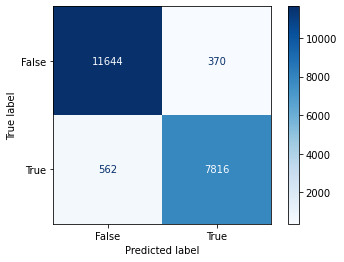

In [311]:
plot_confusion_matrix(decision_tree, x_test, y_test, cmap=plt.cm.Blues);

# Random Forest

In [341]:
random_forest = RandomForestClassifier(n_estimators=100,
                                  criterion = 'entropy',
                                  random_state=42, 
                                  class_weight = 'balanced_subsample',
                                  max_features = 'sqrt',
                                  bootstrap=True, 
                                  n_jobs=-1,
                                  verbose = 1)

In [342]:
random_forest.fit(x_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.5s finished


RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       n_jobs=-1, random_state=42, verbose=1)

In [343]:
y_pred, y_test = prediction_model(random_forest, data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [344]:
randomforest_metrics = calculate_metrics(y_pred, y_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


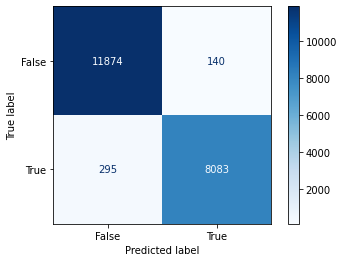

In [345]:
plot_confusion_matrix(random_forest, x_test, y_test, cmap=plt.cm.Blues);

# Catboost

In [347]:
category_features = actual_cat_features(data)
model = train_model(data, category_features)
y_pred, y_test = prediction_model(model, data)
catboost_metrics = calculate_metrics(y_pred, y_test)

0:	learn: 0.5580934	test: 0.5572986	best: 0.5572986 (0)	total: 226ms	remaining: 3m 23s
1:	learn: 0.4442996	test: 0.4422918	best: 0.4422918 (1)	total: 452ms	remaining: 3m 22s
2:	learn: 0.3638697	test: 0.3611280	best: 0.3611280 (2)	total: 667ms	remaining: 3m 19s
3:	learn: 0.3064539	test: 0.3028710	best: 0.3028710 (3)	total: 920ms	remaining: 3m 26s
4:	learn: 0.2675550	test: 0.2639224	best: 0.2639224 (4)	total: 1.12s	remaining: 3m 20s
5:	learn: 0.2355812	test: 0.2319429	best: 0.2319429 (5)	total: 1.38s	remaining: 3m 26s
6:	learn: 0.2017212	test: 0.1974226	best: 0.1974226 (6)	total: 1.67s	remaining: 3m 33s
7:	learn: 0.1765105	test: 0.1712463	best: 0.1712463 (7)	total: 1.93s	remaining: 3m 35s
8:	learn: 0.1612799	test: 0.1560893	best: 0.1560893 (8)	total: 2.23s	remaining: 3m 40s
9:	learn: 0.1505038	test: 0.1451128	best: 0.1451128 (9)	total: 2.5s	remaining: 3m 42s
10:	learn: 0.1409334	test: 0.1350428	best: 0.1350428 (10)	total: 2.77s	remaining: 3m 43s
11:	learn: 0.1313212	test: 0.1255385	best:

In [348]:
y_test = y_test.astype('str')

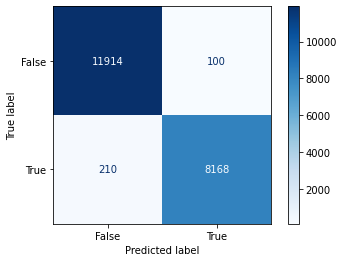

In [349]:
plot_confusion_matrix(model, x_test, y_test, cmap=plt.cm.Blues);

# Сделаем датафрейм с метриками

In [350]:
all_metrics = pd.concat([decisiontree_metrics, randomforest_metrics, catboost_metrics], axis=0)

In [352]:
all_metrics.reset_index(drop=True, inplace=True)

In [355]:
all_metrics

,f1,precision,recall
0,0.9329,0.8991,0.9692
1,0.9609,0.9296,0.9944
2,0.9775,0.9620,0.9935


In [354]:
all_metrics.to_csv('metrics/metrics.csv', index=False)